In [122]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from plotnine import *
from shapely import wkt

pd.set_option('display.max_columns', None)

df_collisions = pd.read_csv(os.path.join('../0_data', 'collisions_data_2000_2022.csv'), usecols = ['accident_index', 
                                                                   'accident_year',
                                                                   'longitude',
                                                                   'latitude',  
                                                                   'accident_severity',
                                                                   'number_of_casualties',
                                                                   'first_road_class',
                                                                   'urban_or_rural_area'], low_memory = False)

df_casualties = pd.read_csv(os.path.join('../0_data', 'casualties_data_2000_2022.csv'), usecols = ['accident_index',
                                                                   'accident_year',
                                                                   'casualty_reference',
                                                                   'casualty_severity'], low_memory = False)

### The population data, as of 2021, is sourced from this dataset: https://www.ons.gov.uk/economy/grossdomesticproductgdp/datasets/regionalgrossdomesticproductallnutslevelregions
gdf_uk_nuts_3_pop = gpd.read_file(os.path.join('spatial_data', 'uk_nuts_3_pop.gpkg'), epsg=3857)

In [123]:
### Check len of unique accidents indeces 
print(len(df_collisions.accident_index))
print(len(df_casualties.accident_index.unique()))

3691651
3691651


In [124]:
### Convert collision df to gdf
geometry = gpd.points_from_xy(df_collisions['longitude'], df_collisions['latitude'])
gdf_collisions = gpd.GeoDataFrame(df_collisions, geometry=geometry, crs='EPSG:4326')
gdf_collisions = gdf_collisions.to_crs(epsg=3857)

In [125]:
### Check if there are any null coordinates
gdf_collisions[gdf_collisions['latitude'].isna() & gdf_collisions['longitude'].isna()]

,accident_index,accident_year,longitude,latitude,accident_severity,number_of_casualties,first_road_class,urban_or_rural_area,geometry
38136,2000030000024,2000,NaN,NaN,3,1,5,3,POINT EMPTY
38149,2000030000046,2000,NaN,NaN,3,3,3,3,POINT EMPTY
38173,2000030000091,2000,NaN,NaN,3,1,3,3,POINT EMPTY
38181,2000030000118,2000,NaN,NaN,3,3,6,3,POINT EMPTY
38186,2000030000132,2000,NaN,NaN,3,1,6,3,POINT EMPTY
...,...,...,...,...,...,...,...,...,...
3659449,2022430277851,2022,NaN,NaN,2,1,1,3,POINT EMPTY
3680034,20225222SE395,2022,NaN,NaN,2,1,6,3,POINT EMPTY
3684522,202260B074252,2022,NaN,NaN,3,1,6,3,POINT EMPTY
3687187,202263C103622,2022,NaN,NaN,3,1,4,3,POINT EMPTY


In [126]:
### Filter out collisions with empty coordinates
gdf_collisions_filtered = gdf_collisions[gdf_collisions['latitude'].notna() & gdf_collisions['longitude'].notna()]
gdf_collisions_filtered

,accident_index,accident_year,longitude,latitude,accident_severity,number_of_casualties,first_road_class,urban_or_rural_area,geometry
0,2000010SU0982,2000,-0.232572,51.688371,3,3,1,2,POINT (-25889.797 6743973.883)
1,2000010SU0983,2000,-0.032110,51.726908,3,1,3,2,POINT (-3574.469 6750896.744)
2,2000010SU0984,2000,-0.271588,51.723752,3,1,5,2,POINT (-30233.038 6750329.572)
3,2000010SU0985,2000,-0.253731,51.706222,3,1,1,2,POINT (-28245.206 6747179.938)
4,2000010SU0986,2000,-0.218557,51.684203,3,1,1,2,POINT (-24329.654 6743225.489)
...,...,...,...,...,...,...,...,...,...
3691646,2022991311627,2022,-4.613246,55.495815,2,1,3,1,POINT (-513544.196 7458694.480)
3691647,2022991312498,2022,-6.348650,55.783849,2,1,3,2,POINT (-706728.485 7515505.890)
3691648,2022991315177,2022,-4.326930,55.843114,3,1,6,1,POINT (-481671.644 7527247.273)
3691649,2022991321308,2022,-3.196963,55.980648,2,1,3,1,POINT (-355884.293 7554564.184)


### Analysis of fatal accidents locations from 2020 to 2022

In [127]:
### Filter only fatal accidents
gdf_collisions_fatal = gdf_collisions_filtered[gdf_collisions_filtered['accident_severity'] == 1]

In [128]:
### Visualizing fatal accidents (2000 - 2022) on a heatmap
import folium
from folium.plugins import HeatMap

coordinates_list = gdf_collisions_fatal[['latitude', 'longitude']].values.tolist()
map_obj = folium.Map(location = [51.27312, -0.5821872], zoom_start = 5, tiles="CartoDB positron")
HeatMap(coordinates_list).add_to(map_obj)

map_obj

In [130]:
### Identifying clusters with a minimum of 5 fatal accidents
import pandas as pd
from sklearn.cluster import DBSCAN
from math import radians

gdf_collisions_fatal.loc[:, 'latitude_rad'] = gdf_collisions_fatal['latitude'].apply(radians)
gdf_collisions_fatal.loc[:, 'longitude_rad'] = gdf_collisions_fatal['longitude'].apply(radians)

X = gdf_collisions_fatal[['latitude_rad', 'longitude_rad']]

# Convert 100 meters to degrees (approximate)
meters_to_degrees = 0.001 / 104

eps = meters_to_degrees
min_samples = 5 # min number of the fatal accidents
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='haversine')

gdf_collisions_fatal.loc[:, 'cluster'] = dbscan.fit_predict(X)

# Filter clusters
gdf_dbscan_clustered = gdf_collisions_fatal.loc[gdf_collisions_fatal['cluster'] != -1]

In [152]:
area_labels = {1: 'Urban', 2: 'Rural'}
gdf_dbscan_clustered.loc[:, 'area_label'] = gdf_dbscan_clustered['urban_or_rural_area'].map(area_labels)
cluster_counts = gdf_dbscan_clustered.groupby('area_label')['cluster'].nunique()
print(cluster_counts)

area_label
Rural    9
Urban    8
Name: cluster, dtype: int64


In [155]:

road_class_labels = {1: 'Motorway', 3: 'A', 4: 'B'}
gdf_dbscan_clustered.loc[:, 'road_class_label'] = gdf_dbscan_clustered['first_road_class'].map(road_class_labels)
cluster_counts2 = gdf_dbscan_clustered.groupby('road_class_label')['cluster'].nunique()
print(cluster_counts2)

road_class_label
A           14
B            1
Motorway     3
Name: cluster, dtype: int64


##### The overall count of clusters is 17, consisting of 8 in urban areas and 9 in rural regions. Specifically, six clusters are found within London, along with an additional one on the Greater London road (Motorway) classified as rural. Further, individual clusters are identified in Bristol and Manchester. The rest are dispersed across the country, predominantly situated along A roads. It is noteworthy that the majority of these clusters are located in England, with one each in Wales and Scotland. Notably, the cluster of 6 fatal accidents in Scotland is positioned at a sharp turn on the road A83 (Old Military Road).

In [133]:
### Visualize clusters 
import folium
from folium.plugins import MarkerCluster

map_center = [gdf_dbscan_clustered['latitude'].iloc[0], gdf_dbscan_clustered['longitude'].iloc[0]]
fatal_clusters_map = folium.Map(location=map_center, zoom_start=6, tiles="CartoDB positron")

marker_cluster = MarkerCluster().add_to(fatal_clusters_map)

for index, row in gdf_dbscan_clustered.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"Cluster: {row['cluster']}",
        icon=folium.Icon(color='red', icon="car-burst", prefix='fa')
    ).add_to(marker_cluster)

fatal_clusters_map.save('fatal_clusters_map.html')  
fatal_clusters_map

### Analyzing accidents, casualties, and fatal casualties by ITL 3 region as of 2021.

In [134]:
### UK ITL 3 overview
gdf_uk_nuts_3_pop.head()

,NUTS_ID,CNTR_CODE,LATIN_NAME,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,ITL,POP_2021,geometry
0,TLM62,UK,"Inverness & Nairn and Moray, Badenoch & Strath...","Inverness & Nairn and Moray, Badenoch & Strath...",2.0,2,1,ITL3,206504,"MULTIPOLYGON (((-311862.555 7903569.183, -3118..."
1,TLM63,UK,"Lochaber, Skye & Lochalsh, Arran & Cumbrae and...","Lochaber, Skye & Lochalsh, Arran & Cumbrae and...",3.0,3,1,ITL3,99774,"MULTIPOLYGON (((-567298.485 7844793.358, -5649..."
2,TLM61,UK,Caithness & Sutherland and Ross & Cromarty,Caithness & Sutherland and Ross & Cromarty,2.0,3,1,ITL3,94501,"MULTIPOLYGON (((-493373.828 7861838.845, -4943..."
3,TLE22,UK,North Yorkshire CC,North Yorkshire CC,4.0,2,1,ITL3,618847,"POLYGON ((-23649.770 7200065.661, -24797.861 7..."
4,TLJ14,UK,Oxfordshire,Oxfordshire,4.0,2,3,ITL3,726530,"POLYGON ((-124461.759 6802916.148, -123777.739..."


In [135]:
### Select 2021 for futher calculations
gdf_collisions_2021 = gdf_collisions_filtered[gdf_collisions_filtered['accident_year'] == 2021]
df_casualties_2021 = df_casualties[df_casualties['accident_year'] == 2021]

In [136]:
### Merge accidents and casualties dataframes
df_casualties_collisions_2021 = pd.merge(df_casualties_2021, gdf_collisions_2021, on='accident_index', how='left')
df_casualties_collisions_2021.head()

,accident_index,accident_year_x,casualty_reference,casualty_severity,accident_year_y,longitude,latitude,accident_severity,number_of_casualties,first_road_class,urban_or_rural_area,geometry
0,2021010287148,2021,1,3,2021.0,-0.246102,51.623425,3.0,1.0,6.0,1.0,POINT (-27395.949 6732320.181)
1,2021010287149,2021,1,3,2021.0,-0.050574,51.509767,2.0,3.0,3.0,1.0,POINT (-5629.872 6711965.828)
2,2021010287149,2021,2,3,2021.0,-0.050574,51.509767,2.0,3.0,3.0,1.0,POINT (-5629.872 6711965.828)
3,2021010287149,2021,3,2,2021.0,-0.050574,51.509767,2.0,3.0,3.0,1.0,POINT (-5629.872 6711965.828)
4,2021010287151,2021,1,3,2021.0,-0.136152,51.417769,2.0,4.0,4.0,1.0,POINT (-15156.371 6695527.593)


In [137]:
### Calculate fatal casualties in 2021
df_casualties_fatal = df_casualties_collisions_2021[df_casualties_collisions_2021['casualty_severity'] == 1]
fatalities_count = df_casualties_fatal.groupby('accident_index')['casualty_reference'].count().reset_index()
fatalities_count.columns = ['accident_index', 'number_of_fatal_casualties']
fatalities_count.sort_values(by='number_of_fatal_casualties', ascending=False)

,accident_index,number_of_fatal_casualties
808,2021401096827,4
1030,2021461096725,4
425,2021161112967,4
1002,2021461036663,3
852,2021421080238,3
...,...,...
507,2021211109564,1
506,2021211104037,1
505,2021211101850,1
504,2021211101236,1


In [138]:
### Merge with collisions dataset
df_collisions_2021_full = pd.merge(gdf_collisions_2021, fatalities_count, on='accident_index', how='left')
df_collisions_2021_full

,accident_index,accident_year,longitude,latitude,accident_severity,number_of_casualties,first_road_class,urban_or_rural_area,geometry,number_of_fatal_casualties
0,2021010287148,2021,-0.246102,51.623425,3,1,6,1,POINT (-27395.949 6732320.181),NaN
1,2021010287149,2021,-0.050574,51.509767,2,3,3,1,POINT (-5629.872 6711965.828),NaN
2,2021010287151,2021,-0.136152,51.417769,2,4,4,1,POINT (-15156.371 6695527.593),NaN
3,2021010287155,2021,-0.196411,51.490536,1,1,3,1,POINT (-21864.373 6708526.885),1.0
4,2021010287157,2021,-0.388169,51.431649,3,1,5,1,POINT (-43210.775 6698005.555),NaN
...,...,...,...,...,...,...,...,...,...,...
101065,2021991196247,2021,-3.194076,55.958152,3,1,6,1,POINT (-355562.914 7550089.409),NaN
101066,2021991196607,2021,-4.010304,54.902512,3,2,3,2,POINT (-446424.999 7342968.622),NaN
101067,2021991197944,2021,-2.716825,57.634805,3,1,4,2,POINT (-302435.576 7890989.579),NaN
101068,2021991200639,2021,-3.172192,55.970735,3,1,3,1,POINT (-353126.798 7552592.027),NaN


In [139]:
### Some points might not overlap with the polygons, check
joined_data = gpd.sjoin(df_collisions_2021_full, gdf_uk_nuts_3_pop, how='left')
points_not_overlapping = joined_data[joined_data['index_right'].isna()]
len(points_not_overlapping)

140

In [140]:
### Spatial join of collisions and UK ITL polygons using sjoin_nearest as there points beyond polygon bondaries
uk_itl_3_collisions_2021 = gpd.sjoin_nearest(df_collisions_2021_full, gdf_uk_nuts_3_pop)
uk_itl_3_collisions_2021.head()

,accident_index,accident_year,longitude,latitude,accident_severity,number_of_casualties,first_road_class,urban_or_rural_area,geometry,number_of_fatal_casualties,index_right,NUTS_ID,CNTR_CODE,LATIN_NAME,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,ITL,POP_2021
0,2021010287148,2021,-0.246102,51.623425,3,1,6,1,POINT (-27395.949 6732320.181),NaN,151,TLI71,UK,Barnet,Barnet,4.0,1,2,ITL3,388639
35,2021010287293,2021,-0.254792,51.642816,3,2,3,2,POINT (-28363.316 6735797.892),NaN,151,TLI71,UK,Barnet,Barnet,4.0,1,2,ITL3,388639
45,2021010287322,2021,-0.175172,51.626885,3,1,3,1,POINT (-19500.058 6732940.612),NaN,151,TLI71,UK,Barnet,Barnet,4.0,1,2,ITL3,388639
49,2021010287329,2021,-0.267550,51.600795,3,1,3,1,POINT (-29783.530 6728263.446),NaN,151,TLI71,UK,Barnet,Barnet,4.0,1,2,ITL3,388639
90,2021010287467,2021,-0.191351,51.599340,3,1,6,1,POINT (-21301.096 6728002.687),NaN,151,TLI71,UK,Barnet,Barnet,4.0,1,2,ITL3,388639


In [141]:
# Group by NUTS_ID to get values for each region
grouped_df = uk_itl_3_collisions_2021.groupby('NUTS_ID').agg({
    'accident_index': 'count',
    'number_of_casualties': 'sum',
    'number_of_fatal_casualties': 'sum'
}).reset_index()

grouped_df.rename(columns={'accident_index': 'accident_count'}, inplace=True)

# Merge with the original polygons GeoDataFrame to get geometry for each region
gdf_uk_nut_3_collisions_2021 = gpd.GeoDataFrame(gdf_uk_nuts_3_pop.merge(grouped_df, on='NUTS_ID', how='left'))

In [142]:
### Check the number of road accidents, casualties and fatal casualties 
print(gdf_uk_nut_3_collisions_2021.accident_count.sum())
print(gdf_uk_nut_3_collisions_2021.number_of_casualties.sum())
print(gdf_uk_nut_3_collisions_2021.number_of_fatal_casualties.sum())

101070.0
128189.0
1557.0


In [143]:
# Calculate number of accidents, casualties, fatal casualties per 1000
gdf_uk_nut_3_collisions_2021['accidents_per_cap'] = gdf_uk_nut_3_collisions_2021['accident_count']/gdf_uk_nut_3_collisions_2021['POP_2021'] * 1000
gdf_uk_nut_3_collisions_2021['casualties_per_cap'] = gdf_uk_nut_3_collisions_2021['number_of_casualties']/gdf_uk_nut_3_collisions_2021['POP_2021'] * 1000
gdf_uk_nut_3_collisions_2021['fatal_cas_per_cap'] = gdf_uk_nut_3_collisions_2021['number_of_fatal_casualties']/gdf_uk_nut_3_collisions_2021['POP_2021'] * 1000
gdf_uk_nut_3_collisions_2021.head()

,NUTS_ID,CNTR_CODE,LATIN_NAME,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,ITL,POP_2021,geometry,accident_count,number_of_casualties,number_of_fatal_casualties,accidents_per_cap,casualties_per_cap,fatal_cas_per_cap
0,TLM62,UK,"Inverness & Nairn and Moray, Badenoch & Strath...","Inverness & Nairn and Moray, Badenoch & Strath...",2.0,2,1,ITL3,206504,"MULTIPOLYGON (((-311862.555 7903569.183, -3118...",96.0,136.0,7.0,0.464882,0.658583,0.033898
1,TLM63,UK,"Lochaber, Skye & Lochalsh, Arran & Cumbrae and...","Lochaber, Skye & Lochalsh, Arran & Cumbrae and...",3.0,3,1,ITL3,99774,"MULTIPOLYGON (((-567298.485 7844793.358, -5649...",137.0,189.0,11.0,1.373103,1.894281,0.110249
2,TLM61,UK,Caithness & Sutherland and Ross & Cromarty,Caithness & Sutherland and Ross & Cromarty,2.0,3,1,ITL3,94501,"MULTIPOLYGON (((-493373.828 7861838.845, -4943...",76.0,106.0,8.0,0.804224,1.121681,0.084655
3,TLE22,UK,North Yorkshire CC,North Yorkshire CC,4.0,2,1,ITL3,618847,"POLYGON ((-23649.770 7200065.661, -24797.861 7...",1011.0,1382.0,35.0,1.633683,2.233185,0.056557
4,TLJ14,UK,Oxfordshire,Oxfordshire,4.0,2,3,ITL3,726530,"POLYGON ((-124461.759 6802916.148, -123777.739...",871.0,1043.0,17.0,1.198849,1.435591,0.023399


In [144]:
### Get 5 regions with the most accidents, casualties and fatal casualties per 1000 inhabitants:
accidents = gdf_uk_nut_3_collisions_2021.nlargest(5, 'accidents_per_cap')[['NUTS_NAME', 'accidents_per_cap']]
print(accidents)

casualties = gdf_uk_nut_3_collisions_2021.nlargest(5, 'casualties_per_cap')[['NUTS_NAME', 'casualties_per_cap']]
print(casualties)

fatalities = gdf_uk_nut_3_collisions_2021.nlargest(5, 'fatal_cas_per_cap')[['NUTS_NAME', 'fatal_cas_per_cap']]
print(fatalities)

                                         NUTS_NAME  accidents_per_cap
88                                     Westminster           5.607376
87                       Camden and City of London           3.798948
133                                        Lambeth           3.757504
89   Kensington & Chelsea and Hammersmith & Fulham           3.712928
92                                   Tower Hamlets           3.580201
                                         NUTS_NAME  casualties_per_cap
88                                     Westminster            6.236378
133                                        Lambeth            4.176404
92                                   Tower Hamlets            4.124596
87                       Camden and City of London            4.082043
89   Kensington & Chelsea and Hammersmith & Fulham            4.003239
                                             NUTS_NAME  fatal_cas_per_cap
1    Lochaber, Skye & Lochalsh, Arran & Cumbrae and...           0.110249
65    

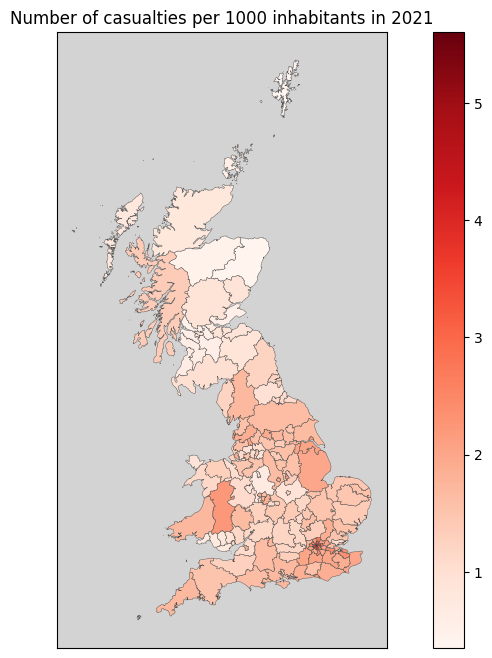

In [145]:
### Number of road accidents per 1000 inhabitants in 2021 in the UK
fig, ax = plt.subplots(figsize=(12, 8))
gdf_uk_nut_3_collisions_2021.plot(column='accidents_per_cap', cmap='Reds', linewidth=0.3, ax=ax, edgecolor='0.3', legend=True)

ax.set_facecolor('lightgrey')
ax.set_xticks([])
ax.set_yticks([])

ax.set_title('Number of casualties per 1000 inhabitants in 2021', fontsize=12)

plt.show()

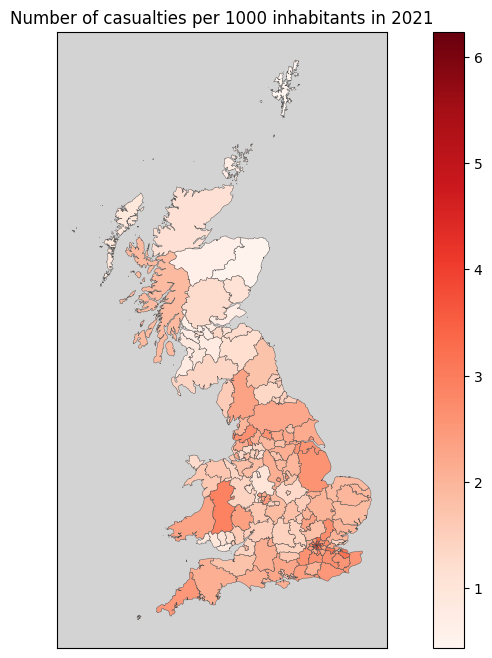

In [146]:
### Number of casualties per 1000 inhabitants in 2021 in the UK
fig, ax = plt.subplots(figsize=(12, 8))
gdf_uk_nut_3_collisions_2021.plot(column='casualties_per_cap', cmap='Reds', linewidth=0.3, ax=ax, edgecolor='0.3', legend=True)

ax.set_facecolor('lightgrey')
ax.set_xticks([])
ax.set_yticks([])

ax.set_title('Number of casualties per 1000 inhabitants in 2021', fontsize=12)

plt.show()

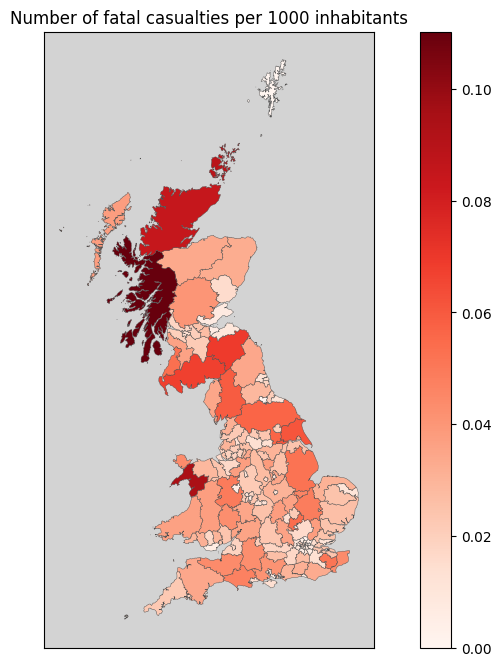

In [103]:
### Number of fatal casualties per 1000 inhabitants in 2021 in the UK
fig, ax = plt.subplots(figsize=(12, 8))
gdf_uk_nut_3_collisions_2021.plot(column='fatal_cas_per_cap', cmap='Reds', linewidth=0.3, ax=ax, edgecolor='0.3', legend=True)

ax.set_facecolor('lightgrey')
ax.set_xticks([])
ax.set_yticks([])

ax.set_title('Number of fatal casualties per 1000 inhabitants', fontsize=12)

plt.show()

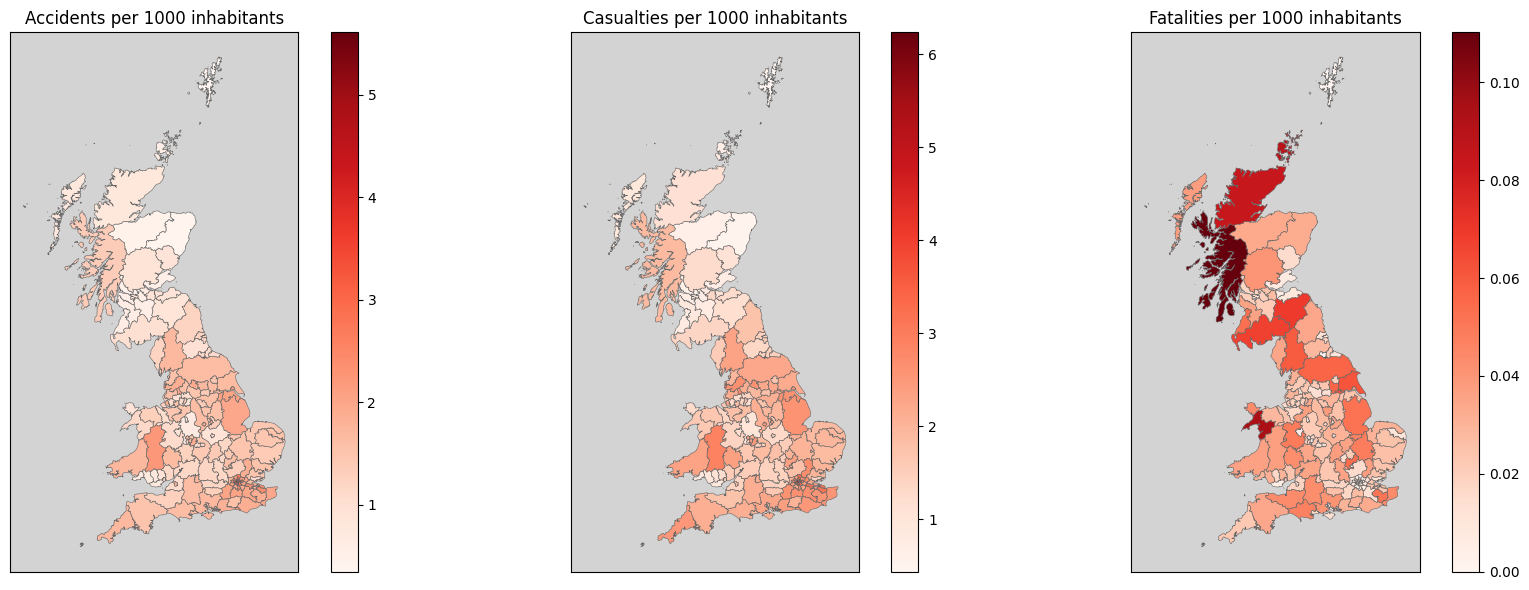

In [104]:
### Visualise 3 maps 
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

gdf_uk_nut_3_collisions_2021.plot(column='accidents_per_cap', cmap='Reds', linewidth=0.4, ax=axs[0], edgecolor='0.4', legend=True)
axs[0].set_facecolor('lightgrey')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Accidents per 1000 inhabitants', fontsize=12)

gdf_uk_nut_3_collisions_2021.plot(column='casualties_per_cap', cmap='Reds', linewidth=0.4, ax=axs[1], edgecolor='0.4', legend=True)
axs[1].set_facecolor('lightgrey')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Casualties per 1000 inhabitants', fontsize=12)

gdf_uk_nut_3_collisions_2021.plot(column='fatal_cas_per_cap', cmap='Reds', linewidth=0.4, ax=axs[2], edgecolor='0.4', legend=True)
axs[2].set_facecolor('lightgrey')
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title('Fatalities per 1000 inhabitants', fontsize=12)

plt.tight_layout()
plt.show()